# Chapter 16: Modeling Intro

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2026-01-14

# Intro to Modeling - Getting Started with HBV

## Introduction

The following activity is available as a template github repository at
the following link:

**Before we start with the code below, we will briefly discuss modeling
in general, using the following reading as a guide:
<https://cfpub.epa.gov/si/si_public_record_report.cfm?dirEntryId=339328&Lab=NERL>**

**Please be prepared to discuss the reading at the start of class.**

*Goals for this activity:*

-   Become familiar with the process of running a simple hydrologic
    model
-   Try parameterizing the model manually
-   Introduction to methods of assessing model success

In [ ]:
library(tidyverse)
library(lubridate)
library(patchwork)
library(plotly)

theme_set(theme_classic())

## Creating the HBV model function

The code for the HBV model is in the HBV folder, it is called *HBV.R*.
We will open that and look at the code a bit to discuss how HBV works.

The code in HBV.R creates a function that runs the HBV model. We can run
that code by using the source() function in. When we give the location
of the HBV.R file to source(), it runs the code and creates the HBV
function. Run the line of code below, then type HBV( and you’ll see the
input parameters pop up just like any other function.

From this we see that HBV takes as input pars, P, Temp, PET, and
routing.

pars is a vector of all the parameters that HBV uses to run (discussed
below) P is a vector of precipitation values Temp is a vector of
temperature values PET is a vector of PET values And routing is a
parameter that controls how water is routes through the channel of
larger watersheds. We will not use this because we are running the model
on a small watershed.

HBV is a lumped conceptual model. We will use the diagram below and the
HBV.R code to discuss how the model works and get an idea of what the
parameters do.

![](attachment:images/HBV-schem-Shrestha-Solomantine-2008.png "HBV Model")

*HBV Model*

This schematic was reproduced from: Durga Lal Shrestha & Dimitri P.
Solomatine (2008) Data‐driven approaches for estimating uncertainty in
rainfall‐runoff modelling, International Journal of River Basin
Management, 6:2, 109-122, DOI: 10.1080/15715124.2008.9635341
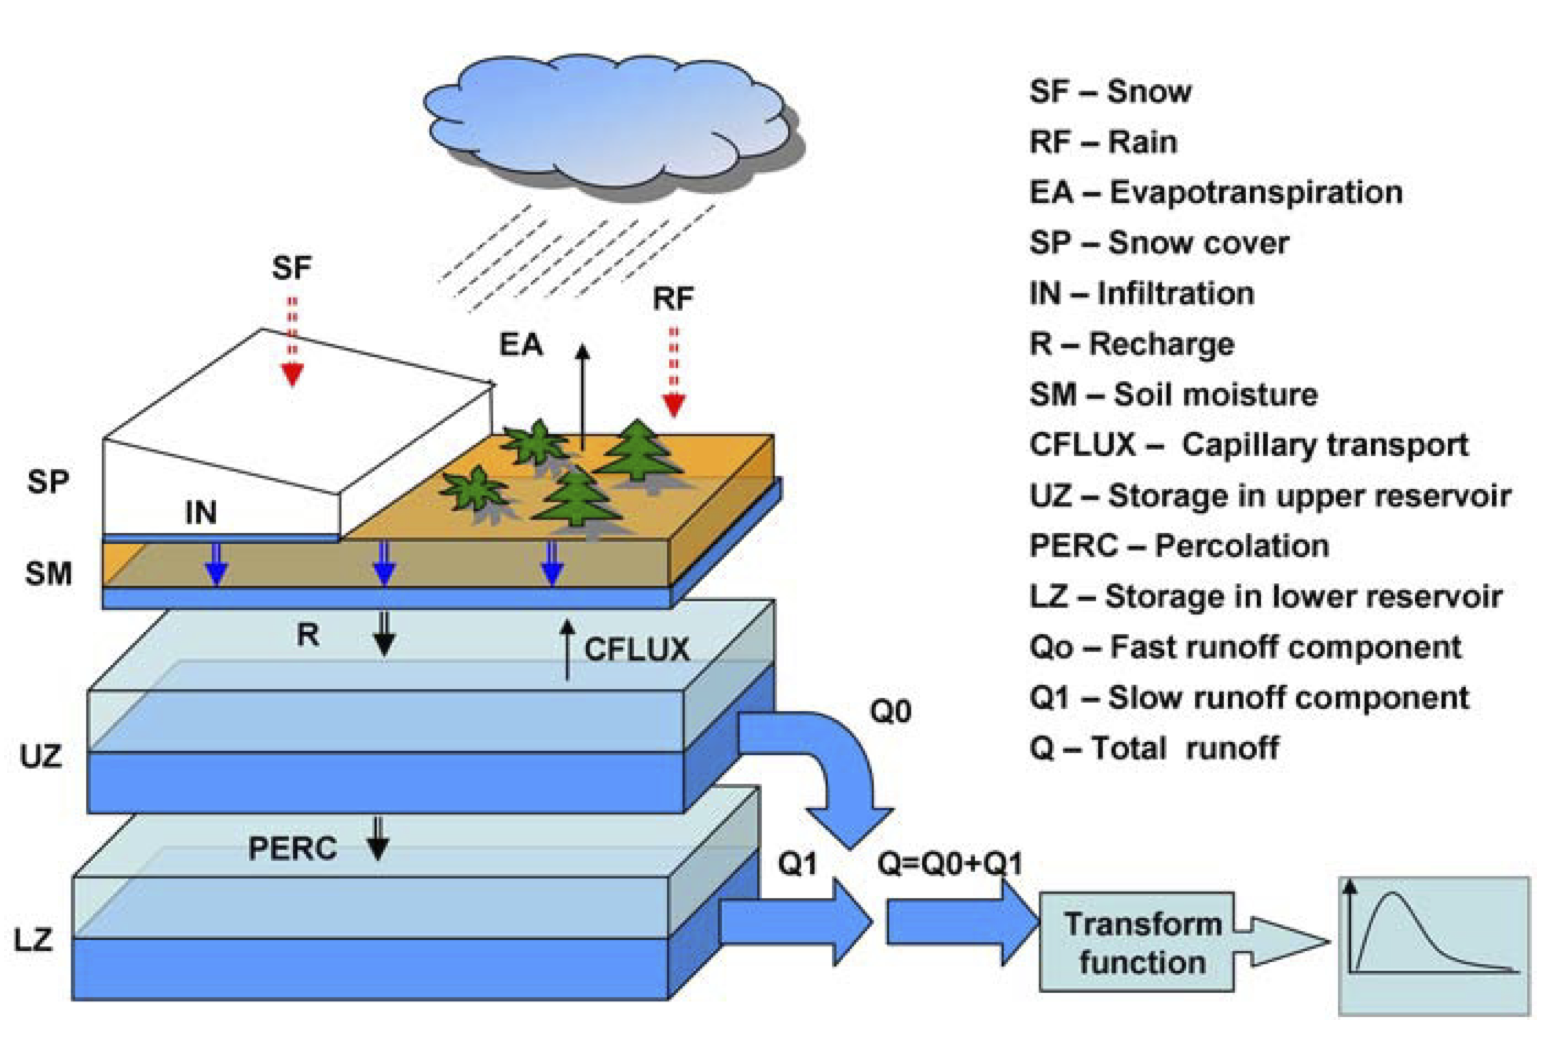

In [ ]:
source('HBV/HBV.R')

## Read in Precip and Temp

Our objective today is basically to get the model running with data from
watershed 3 at the Hubbard Brook experimental forest in NH, USA.

Watershed 3 is a hydrologic reference watershed at HBEF. This means it
hasn’t been experimentally manipulated, but discharge, temperature, and
precipitation have been recorded there for a long time. This makes it a
good candidate for some modeling! You can see more about watershed 3
here: <https://hubbardbrook.org/watersheds/watershed-3>

As we saw in the chunk above, we need P, Temp, PET, and a set of
parameters to run the model.

We will talk parameters later, but for now we need the data that drives
the model: P, Temp, and PET.

We have P and Temp. The data is in Pwd2009-2012.csv and
Tdm2009-2012.csv.

So how do we get PET?

We calculate it! But before we do that let’s bring in the precip and
temp data and format them how the model wants them.

Our model function just wants a vector of values. No dates attached. So
we must be careful that each set of input data is for the same amount of
time with the same number of values. To help with that, we will start
below by defining and start and end date for the model run.

Finally, we will read in the data, select the gage or station we want to
represent the watershed, change the format of the date column, and then
filter to our start and end date.

Then we will pull out just the data, so it can be passed to the model.

In [ ]:
start <- mdy("01-01-2009")
end <- mdy("12-31-2012")

#Precip
P1 <- read_csv("HBV/Pwd2009-2012.csv") %>% 
         select(DATE, WS_3) %>%
         mutate(DATE = ymd(DATE)) %>%
         filter(DATE >= start & DATE <= end)

Rows: 1461 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): DATE, WS_1, WS_2, WS_3, WS_4, WS_5, WS_6, WS_7, WS_8, WS_9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 1461 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): DATE, STA_1, STA_6, STA_14, STA_INT, STA_HQ, STA_23, STA_17, STA_24

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Calculate PET

Next, we need to calculate PET for the same time reange as our
temperature and precipitation record.

We will use the Hamon method to calculate PET for each day of the
record.

To do that we will take the latitude of the site in radians…

In [ ]:
lat <- 43 + 57/60 #43 degrees and 57 minutes
latrad <- (lat/360) * 2 * pi #convert to radians

PET1 <- select(Temp1, DATE) %>%
         mutate(DOY = yday(DATE)) %>% #DOY for dates
         mutate(tempvar = (2 * pi / 365) * DOY) %>%
         #declination of the sun above the celestial equator in 
         #radians on day JulDay of the year
         mutate(delta_h = 0.4093 * sin(tempvar - 1.405)) %>% 
         #day length in h
         mutate(daylen = (2 * acos(-tan(delta_h) * tan(latrad)) / 0.2618)) %>% 
         mutate(
           PET = 29.8 * daylen * 0.611 * exp(17.3 * Temp / 
                  (Temp + 237.3)) / (Temp + 273.2))  #PET Hamon method

PET <- PET1$PET

## HBV Parameters

Okay, so now we have our data set up. Next we need to talk parameters.

The table below shows the parameters of the HBV model, the minimum and
maximum for those values, and a description of their function in the
model.

| Object Name | Min   | Max  | Description                                                              |
|-----------------------|-------------|-----------|-------------------------|
| FC          | 40    | 400  | Max soil moisture storage, field capacity                                |
| beta        | 1     | 6    | Shape coefficient governing fate of water input to soil moisture storage |
| LP          | .3    | 1    | Threshold for reduction of evaporation                                   |
| SFCF        | 0.4   | 1.2  | Snowfall correction factor                                               |
| TT          | -1.5  | 1.2  | Threshold temperature                                                    |
| CFMAX       | 1     | 8    | Degree-day factor                                                        |
| k0          | 0.05  | 0.5  | Recession constant (upper storage, near surface)                         |
| k1          | 0.01  | 0.3  | Recession constant (upper storage)                                       |
| k2          | 0.001 | 0.15 | Recession constant (lower storage)                                       |
| UZL         | 0     | 70   | Threshold for shallow storage                                            |
| PERC        | 0     | 4    | Percolation, max flow from upper to lower storage                        |
| MAXBAS      | 1     | 3    | base of the triangular routing function, days”                           |

To pass a set of parameters to the model, we just put them into a single
vector in the order they are in the table above. In the chunk below,
I’ve structured this to make it easy to see a description of each
parameter, but you could also just do it in one line without all the
comments. Just be sure to get the order right!

The code below sets the routing to 0, which is what we want for a small
catchment.

Then I just set each parameter to it’s minimum value. We will use this
parameter set to run the model and see what happens!

In [ ]:
#when this term = 1, then triangular routing is invoked, or for no routing, routing = 0
#if routing = 0 then MAXBAS doesn't do anything
routing <- 0      

#hard code parameters 
params <- c(40,    #FCM ax soil moisture storage, field capacity
            1,     #beta Shape coefficient governing fate of water input to soil moisture storage
            0.3,   #LP Threshold for reduction of evap
            0.4,   #SFCF Snowfall correction factor
            -1.5,  #TT Threshold temperature
            1,     #CFMAX Degree-day factor
            0.05,  #k0 Recession constant (upper storage, near surface)
            0.01,  #k1 Recession constant (upper storage)
            0.001, #k2 Recession constant (lower storage)
            0,     #UZLThreshold for shallow storage
            0,     #PERC Percolation, max flow from upper to lower storage
            1      #MAXBAS base of the triangular routing function, days
            )

## First model run

Let’s run the model! Remember the function is HBV(parameters, Precip,
Temp, PET, routing)

We will set the output of the model equal to ModelOutput and then have a
look at what it outputs.

How can we tell how this did at modeling flow in watershed 3?

In [ ]:
ModelOutput <- HBV(params, P, Temp, PET, routing)

head(ModelOutput)

# A tibble: 6 × 12
      q    qs    qi    qb Storage   SWE   AET    SF    S1    S2  soil     w
  <dbl> <dbl> <dbl> <dbl>   <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1     0     0     0     0       0    0      0  0        0     0     0     0
2     0     0     0     0      40  152.     0  0        0     0    40     0
3     0     0     0     0      40  152.     0  0        0     0    40     0
4     0     0     0     0      40  152.     0  0        0     0    40     0
5     0     0     0     0      40  154.     0  1.16     0     0    40     0
6     0     0     0     0      40  154.     0  0        0     0    40     0

## Import observed streamflow data

q in the model output is discharge, and we also have a record of
measured discharge from watershed 3 in the file called SWD2009-2012.csv

In order to compare the modeled discharge to the measured discharge, we
will read in the data and process it the same way we did with the model
inputs. Then we can attach it to the model output so we can compare the
two.

NOTE: These data are all nicely processed. They have the same temporal
resolution (daily), there are no NAs, and they are in the same units.
These are all things to check if you are preparing data from another
site.

In [ ]:
#Streamflow mm/d
Qobs1 <- read_csv("HBV/SWD2009-2012.csv") %>%
         select(DATE, WS_3) %>%
         mutate(DATE = ymd(DATE)) %>%
         filter(DATE >= start & DATE <= end)

Rows: 1461 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): DATE, WS_1, WS_2, WS_3, WS_4, WS_5, WS_6, WS_7, WS_8, WS_9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

## Compare observed and modeled discharge graphically

Now that we have the observed values glued on to our model output, we
can plot the two and see how they compare. Below we will plot the
modeled and observed discharge as two lines on a ggplot.

Because the model starts out with its storages at zero, it takes some
time for it to actually approximate real conditions. For this reason,
you will typically set aside part of the modelled period as a “warm up”
period. The duration of this period depends on the system, but for our
purposes, we are doing to drop the first half of the model run and only
look at the second half: 2011 - 2013. So we will filter the data to just
look at that time.

How’d we do? Did the model do a good job of capturing runoff dynamics in
watershed 3?

Describe what it looks like the model did well and what it did poorly?

When you are looking at results like this, it is often helpful to look
at the full timeframe but to also zoom in and look at specific event
dynamics to see what hydrologic processes the model is or is not
capturing well. One helpful tool at doing that is plotly. Plotly allows
you to create interactive plots. The code chunk after the ggplot creates
a plotly graph. From here on out we will use plotly to look at our
modeling results so we can investigate them more thoroughly.

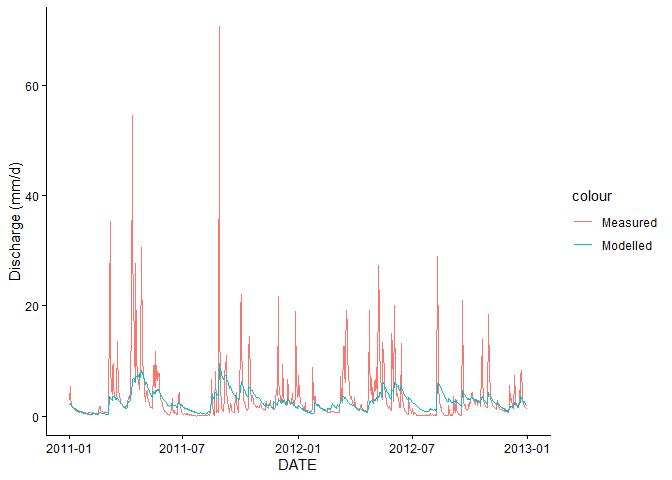

In [ ]:
OutputTrim <- filter(ModelOutput, DATE >= mdy("01-01-2011"))

ggplot(OutputTrim, aes(x = DATE, y = WS_3, color = "Measured"))+
  geom_line()+
  geom_line(aes(y = q, color = "Modelled"))+
  ylab("Discharge (mm/d)")

## Compare observed and modelled discharge with interactive graph

The code below creates a plot analogous to the ggplot above. Note the
differences in syntax. All the same information is there, it is just a
different recipe, and you use pipes instead of +.

You can click and drag a box over any time you want to look at to zoom,
and if you hover over one of the lines, it will show you the values in a
dialogue box. There is a lot of other functionality as well, which you
can explore in the menu in the upper right.

You can create a similar graph by saving the one above and passing it to
ggplotly()!

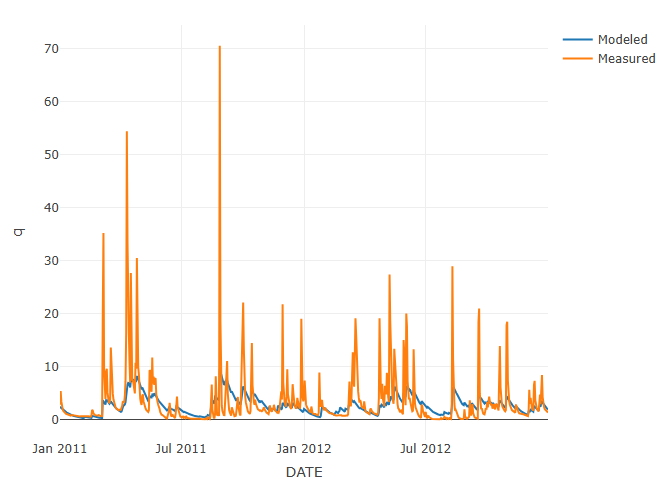

In [ ]:
OutputTrim %>% plot_ly(x = ~DATE) %>% 
        add_trace(y = ~q, name = 'Modeled',  type = 'scatter', mode = 'lines') %>% 
        add_trace(y = ~WS_3, name = 'Measured',  type = 'scatter', mode = 'lines')

**[View interactive plot here](images/discharge_plotly_plot.html)**

## Measure how well the model fits with NSE

Before we can start trying to tune our model to look more like the
observed discharge record, it would be helpful to have some sort of
quantified metric for how well our modeled data fits the measured data.

There are many different ways to do this, but discussion of the pros and
cons of those approaches is beyond this quick introduction to modeling.
So we are just going to look at one method, the Nash-Sutcliffe
Efficiency (NSE).

Basically, the NSE looks at how much better your model run did that if
you had just used the mean discharge for the data record as your
“modeled results”. It does this by comparing how far off the observed
values were from the mean discharge to how far off the modeled values
were from the observed discharge.

Mathematically NSE is the sum of the squared differences between the
modeled and observed discharge divided by the sum of the squared
differences between the observed and mean discharge, subtracted by 1.

$$
NSE = 1 - \frac{\sum_{t = 1}^{T}{(Q_m^t - Q_o^t)^2}}{\sum_{t = 1}^{T}{(Q_o^t - \bar{Q_o})^2}}
$$ Where $Q_m^t$ is modeled discharge at time t, $Q_o^t$ is observed
discharge at time t, and $\bar{Q_o}$ is mean observed discharge.

Below, we calculate NSE for the model run above. We will continue to
exclude the warm up period.

An NSE over 0 means the model did better than the mean discharge at
predicting discharge. An NSE of 1 would be a perfect model fit. How’d we
do? Does this make sense with the timeseries we looked at above?

In [ ]:
#Calculate NSE
NSE <- 1 - ((sum((OutputTrim$q - OutputTrim$WS_3) ^ 2)) / 
                 sum((OutputTrim$WS_3 - mean(OutputTrim$WS_3)) ^ 2))

NSE

[1] 0.2135378

## Assess model fit with a different measure: Snow

Before we jump into trying to parameterize this thing, I wanted to note
that there are other things you can calibrate your model to other than
discharge. In the case of watershed 3, for example, we also have a snow
record. Snowmelt is a very important input driving our model so we might
want to make sure that the model is doing a good job of capturing that
as well!

Let’s pull in snow, calculate NSE between the modeled and measure snow,
and look at a plot of the data.

Snow is not measured daily, so we will plot the measured values as
points. Likewise, we will have filter our data to only times when we
have a modeled snow amount AND a recorded snow amount when we calculate
NSE.

New names:
Rows: 76 Columns: 25
── Column specification
──────────────────────────────────────────────────────── Delimiter: "," chr
(1): DATE dbl (21): STA1, STA2, STA3, STA4, STA5, STA6, STA7, STA8, STA9,
STA10, STA11... lgl (3): ...23, ...24, ...25
ℹ Use `spec()` to retrieve the full column specification for this data. ℹ
Specify the column types or set `show_col_types = FALSE` to quiet this message.
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`

ℹ In argument: `DATE = ymd(DATE)`.
Caused by warning:
!  8 failed to parse.

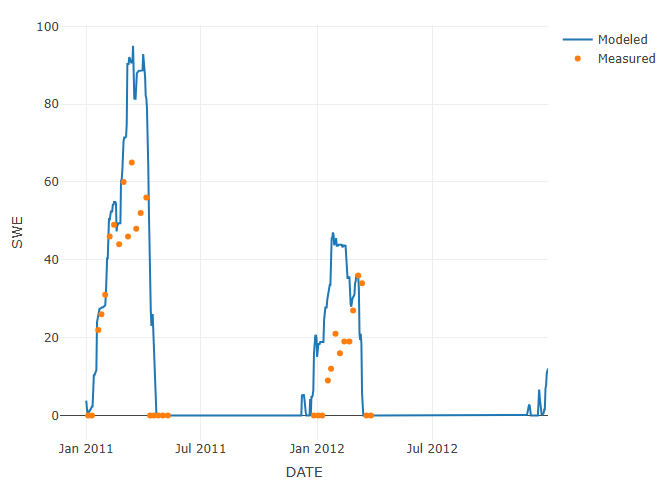

[1] 0.1339054

In [ ]:
#Read and prep snow data
snow <- read_csv("HBV/sno2009-2012.csv") %>%
         select(DATE, STA2) %>%
         mutate(DATE = ymd(DATE)) %>%
         filter(DATE >= start & DATE <= end)

**[View interactive plot here](images/snow_model_plot.html)**

## Calibrate HBV manually

Woohoo! We can now run our model and assess how well it is working!

Now, let’s see how well we can get it to work. The code below runs the
model, produces a plot, and calculates the NSE based on discharge.

By changing the parameters, see how well you can get the model to fit.
Take note of how the discharge changes when you change certain
parameters. Let’s see who can get the highest NSE!

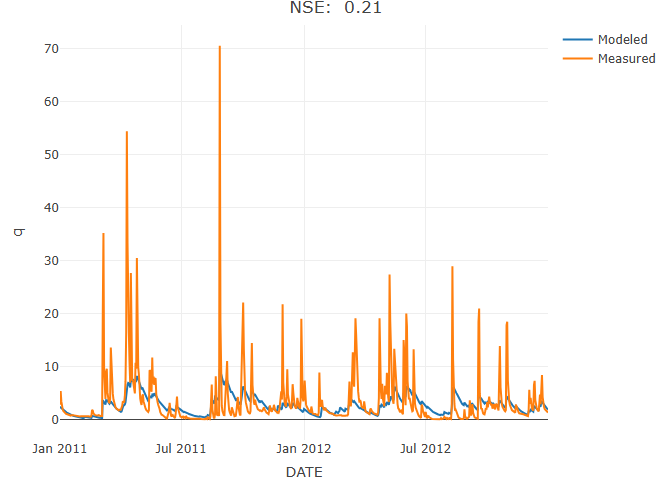

In [ ]:
#when this term = 1, then triangular routing is invoked, or for no routing, routing = 0
#if routing = 0 then MAXBAS doesn't do anything
routing <- 0      

#hard code parameters 
params <- c(40,     #FCM ax soil moisture storage, field capacity
            1,      #beta Shape coefficient governing fate of water input to soil moisture storage
            0.3,    #LP Threshold for reduction of evap
            0.4,    #SFCF Snowfall correction factor
            -1.5,   #TT Threshold temperature
            1,      #CFMAX Degree-day factor
            0.05,   #k0 Recession constant (upper storage, near surface)
            0.01,   #k1 Recession constant (upper storage)
            0.001,  #k2 Recession constant (lower storage)
            0,      #UZL Threshold for shallow storage
            0,      #PERC Percolation, max flow from upper to lower storage
            1       #MAXBAS base of the triangular routing function, days
            )

#Run the model
Out <- HBV(params, P, Temp, PET, routing)

#Add observed output
Out <- bind_cols(Out, Qobs1)

#Trim out the warm up period
OutTrim <- filter(Out, DATE >= mdy("01-01-2011"))

#Calculate NSE
NSE <- 1 - ((sum((OutTrim$q - OutTrim$WS_3) ^ 2)) / 
                 sum((OutTrim$WS_3 - mean(OutTrim$WS_3)) ^ 2))

#Create plot with NSE in title
OutTrim %>% plot_ly(x = ~DATE) %>% 
        add_trace(y = ~q, name = 'Modeled',  type = 'scatter', mode = 'lines') %>% 
        add_trace(y = ~WS_3, name = 'Measured', type = 'scatter', mode = 'lines') %>% 
        layout(title=paste("NSE: ", round(NSE,2)))

**[View interactive plot here](images/snow_model_plot_nse.html)**